## DP-SGD vs. SGD on CelebA Dataset

The purpose of this notebook is to carve out a balanced subset for the *Eyeglasses* attribute, preprocess it once, then train the same CNN twice: one with standard SGD, one with DP-SGD.  
That way, every comparison is fair—same setup, same sweeps, different optimizers.

### Plan
- Balance the split (eyeglasses vs. no_eyeglasses)  
- Preprocess: center-crop → resize (64) → compute channel stats  
- Keep receipts: `stats.json`, `manifest.csv`, `processing_summary.json`, `data_ledger.json`  
- Train baseline CNN (grid search)  
- Train DP-SGD CNN (grid search)  
- Compare accuracy and privacy cost  

### Notes
- Needs CelebA at `data/celeba/archive/` (see `README.md`)  
- Relies on helpers under `src/*`; run cells top-to-bottom on a fresh kernel  
- Seeds are set where they matter; elsewhere, we call out the trade-offs  

### 1. Setup & Config

Every good run starts with a clean slate.  
Here we set the seed, tidy up paths, and make sure our helpers are within reach.  

Think of this step as laying the foundation: if the environment is reproducible and the wiring is clear, the rest of the workflow follows smoothly.  

Run these cells first on a fresh kernel.  
If you adjust paths or edit code under `src/*`, rerun them before moving on.


In [1]:
# --- Setup: imports, seeding, and path hygiene ---
# Reproducibility: seed randomness, configure logging, locate repo root, set plotting style.

# Stdlib
import os
import sys
import logging
import random
from pathlib import Path

# Third-party
import numpy as np
try:
    import matplotlib.pyplot as plt
except ImportError as e:
    raise ImportError("matplotlib is required. Try: pip install matplotlib") from e

# Logging: notebooks can re-run cells, so reset handlers.
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s", force=True)
logger = logging.getLogger("setup")

# Seed
RANDOM_SEED = int(os.environ.get("RANDOM_SEED", "42"))
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
try:
    import torch  # optional, if you use it later
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except Exception:
    # Torch isn't required for this cell; skip silently if absent.
    pass

# Find repo root (first parent containing 'src')
def find_repo_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "src").exists():
            return candidate
    raise RuntimeError("Could not locate repository root containing a 'src' directory.")

PROJECT_ROOT = find_repo_root(Path.cwd())

# Ensure repo root is on sys.path (front)
root_str = str(PROJECT_ROOT)
if root_str not in sys.path:
    sys.path.insert(0, root_str)

# Plot style with fallback (avoid version-specific failure)
try:
    plt.style.use("seaborn-v0_8-whitegrid")
except Exception:
    plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.dpi"] = 120


logger.info(f"Random seed: {RANDOM_SEED}")


INFO: Random seed: 42


In [2]:
# --- Workflow glue: reload helpers and define Config ---
# Reload workflow module, pull core functions, set data paths, and build cfg.

import importlib

try:
    import src.celeba_workflow as _cw
    _cw = importlib.reload(_cw)
except Exception as e:
    raise ImportError(
        "Failed to import or reload 'src.celeba_workflow'. "
        "Check that 'src/' is under the repo root and module imports are valid."
    ) from e

from src.celeba_workflow import (
    Config,
    review_archive,
    analyze_original_subset,
    analyze_processed,
)
from src.nb_display import _relpath as _rp

# Paths
datadir = (PROJECT_ROOT / "data" / "celeba").resolve()
ARCHIVE_DIR = datadir / "archive"
IMAGES_ROOT = ARCHIVE_DIR / "img_align_celeba" / "img_align_celeba"
OUTPUT_DIR = (PROJECT_ROOT / "data" / "celeba" / "subsets" / "eyeglasses_balanced_20k").resolve()
OUT_ROOT = (PROJECT_ROOT / "data" / "celeba" / "processed" / "eyeglasses_balanced_20k_64").resolve()

for p in (OUTPUT_DIR, OUT_ROOT):
    p.mkdir(parents=True, exist_ok=True)

cfg = Config(
    archive_dir=ARCHIVE_DIR,
    images_root=IMAGES_ROOT,
    output_dir=OUTPUT_DIR,
    subset_root=OUTPUT_DIR,
    out_root=OUT_ROOT,
)

logger.info("Config ready.")
logger.info(f"Archive:  {_rp(ARCHIVE_DIR)}")
logger.info(f"Images:   {_rp(IMAGES_ROOT)}")
logger.info(f"Subset:   {_rp(OUTPUT_DIR)}")
logger.info(f"Processed:{_rp(OUT_ROOT)}")


INFO: Config ready.
INFO: Archive:  data/celeba/archive
INFO: Images:   data/celeba/archive/img_align_celeba/img_align_celeba
INFO: Subset:   data/celeba/subsets/eyeglasses_balanced_20k
INFO: Processed:data/celeba/processed/eyeglasses_balanced_20k_64


In [3]:
# --- Preview key config values ---
print("Paths:\n- archive_dir:", cfg.archive_dir,
      "\n- images_root:", cfg.images_root,
      "\n- subset_root:", cfg.subset_root,
      "\n- out_root:", cfg.out_root)
print("\nSubset caps (per class):", {"train": cfg.max_train, "val": cfg.max_val, "test": cfg.max_test})
print("Preprocess:", {"size": cfg.preprocess_size,
                     "center_crop": cfg.preprocess_center_crop,
                     "normalize_01": cfg.preprocess_normalize_01,
                     "compute_stats": cfg.preprocess_compute_stats})
print("Flags:", {"plot": cfg.plot, "dry_run": cfg.dry_run, "overwrite": cfg.overwrite})


Paths:
- archive_dir: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/archive 
- images_root: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/archive/img_align_celeba/img_align_celeba 
- subset_root: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/subsets/eyeglasses_balanced_20k 
- out_root: /Users/caroline/Cursor/dp_sgd_classification/data/celeba/processed/eyeglasses_balanced_20k_64

Subset caps (per class): {'train': 8000, 'val': 1000, 'test': 1000}
Preprocess: {'size': 64, 'center_crop': True, 'normalize_01': True, 'compute_stats': True}
Flags: {'plot': True, 'dry_run': False, 'overwrite': True}


### 2. Review the Archive

Before sampling, we count. This step checks what’s available in the original CelebA dataset, how attributes distribute, and where gaps could trip us later.  
It scans the archive, plots the most common attributes, and flags missing or corrupt files early.  

If the charts look implausible, stop here. A balanced subset starts with honest counts.  

---

#### What you’ll see with the default config

- **Files present**: `list_attr_celeba.csv`, `list_eval_partition.csv`, `list_bbox_celeba.csv`, `list_landmarks_align_celeba.csv` — all found.  
- **Scope**: 202,599 rows • 40 attributes.  
- **Official splits**: train 162,770 • val 19,867 • test 19,962.  
- **Attribute balance**: strongly skewed; most attributes are common, but **Eyeglasses ≈ 6.5%** overall (rare → we’ll need balancing).  
- **Split drift**:  
  - Eyeglasses is stable across splits (train 6.5%, val 7.0%, test 6.5%; deltas ≤ 0.4 pp).  
  - Most attributes show small shifts; the largest is around −3 pp for `Male` in test.  
- **Receipts saved**: summary CSV at `data/celeba/archive/celeba_balance_summary.csv` and plots under `data/celeba/archive/balance_plots/`.  


Review archive with: {'archive_dir': 'data/celeba/archive', 'plot_top_n_attrs': 20}


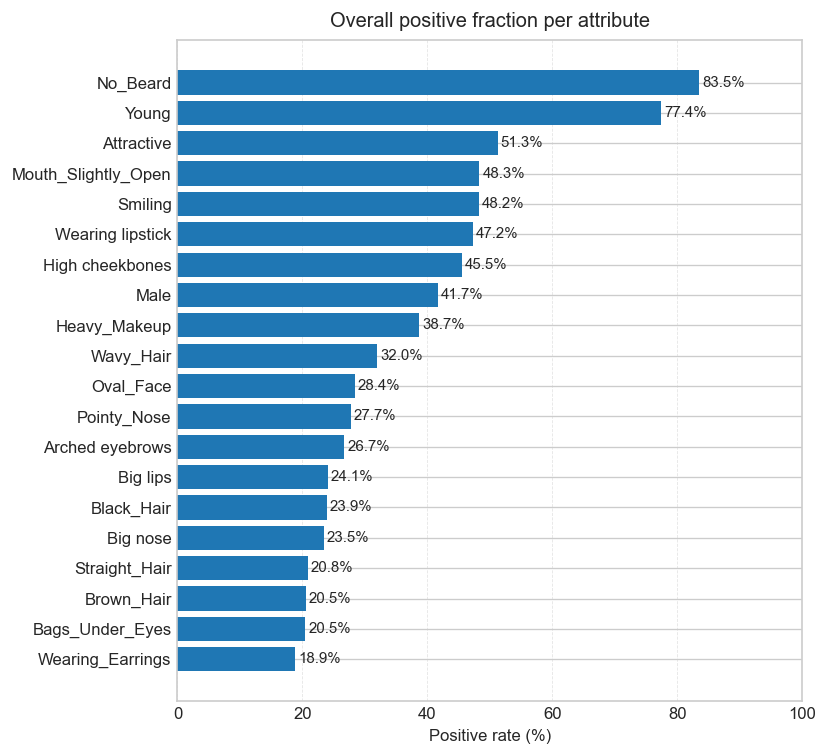

INFO: Review archive section completed.


In [4]:
# --- Review archive: scan attribute distributions and check data health ---
from src.nb_display import _relpath

print("Review archive with:", {
    "archive_dir": _relpath(cfg.archive_dir), # data/celeba/archive
    "plot_top_n_attrs": cfg.plot_top_n_attrs # 20
})

review_archive(cfg)

### 3. Build Subset — and Track What We Skip

Archives have holes. When we carve out a balanced *Eyeglasses* subset, we also log any files we can’t copy or link.  
That way, the dataset we train on is both balanced and accountable.  

---

#### What happens here
- Target caps: **train 8k per class**, **val 1k per class**, **test 1k per class**  
- Final splits:  
  - Train → 8,000 eyeglasses + 8,000 no_eyeglasses (16,000 total)  
  - Val → 1,000 + 1,000 (2,000 total)  
  - Test → 1,000 + 1,000 (2,000 total)  
- Audit trail: wrote `subset_index_eyeglasses.csv` under `data/celeba/subsets/eyeglasses_balanced_20k`  
- Skipped images: **2,718** missing/corrupt (logged to `skipped_missing_images.csv`)  

---

If the skipped count looks large, check the CSV before continuing.  
A clean subset starts with a clean ledger.


In [5]:
# 2) Build subset
print("Build subset with:", {
    "attribute": cfg.attribute, # Eyeglasses    
    "max_train": cfg.max_train, # 10000
    "max_val": cfg.max_val, # 1000
    "max_test": cfg.max_test, # 1000
    "link_mode": cfg.link_mode, # "link"
    "overwrite": cfg.overwrite, # False
    "dry_run": cfg.dry_run, # False
    "output_dir": str(cfg.output_dir),
})
# Capture and summarize skipped images; write skipped_missing_images.csv
from src.celeba_workflow import build_subset_with_skip_summary
build_subset_with_skip_summary(cfg, suppress_per_file_logs=True)


INFO: Running build-subset (captured): celeba_build_subset --archive-dir data/celeba/archive --images-root data/celeba/archive/img_align_celeba/img_align_celeba --output-dir data/celeba/subsets/eyeglasses_balanced_20k --attribute Eyeglasses --max-per-class-train 8000 --max-per-class-val 1000 --max-per-class-test 1000 --link-mode copy --seed 42 --overwrite


Build subset with: {'attribute': 'Eyeglasses', 'max_train': 8000, 'max_val': 1000, 'max_test': 1000, 'link_mode': 'copy', 'overwrite': True, 'dry_run': False, 'output_dir': '/Users/caroline/Cursor/dp_sgd_classification/data/celeba/subsets/eyeglasses_balanced_20k'}
Using attribute: Eyeglasses
Images root: data/celeba/archive/img_align_celeba/img_align_celeba
Output dir: data/celeba/subsets/eyeglasses_balanced_20k
Link mode: copy; dry-run=False; overwrite=True
Split train: target per-class cap 8000
  Kept 8000 pos, 8000 neg (total 16000)
Split val: target per-class cap 1000
  Kept 1000 pos, 1000 neg (total 2000)
Split test: target per-class cap 1000
  Kept 1000 pos, 1000 neg (total 2000)
Wrote index CSV: data/celeba/subsets/eyeglasses_balanced_20k/subset_index_eyeglasses.csv
Created files under: data/celeba/subsets/eyeglasses_balanced_20k
Skipped missing images: 2718 (written to data/celeba/subsets/eyeglasses_balanced_20k/skipped_missing_images.csv)


### 4. Analyze the Subset (Before Preprocessing)

Now that the subset is built, we pause to measure it directly.  
Why? Because it’s the **working dataset** we’ll actually train on.  
Catching size quirks or odd channel stats here is cheaper than discovering them mid-training.  

---

#### What we see
- **Scope**: 20,000 images under `cfg.subset_root`  
- **Balance**: perfect 50/50 split across train, val, and test (no drift)  
- **Image geometry**: uniform `178×218` (aspect ≈ 0.82)  
- **Crop effect**: center-square retains ~82% of pixels consistently  
- **Channel stats (raw [0,1])**:  
  - mean_rgb ≈ (0.501, 0.427, 0.391)  
  - std_rgb  ≈ (0.312, 0.293, 0.293)  

The subset appears clean, balanced, and predictable.  
We have solid baseline stats and it's safe to proceed with preprocessing.


In [6]:
# 3) Analyze subset before preprocessing 
print("Analyze original with:", {"subset_root": str(cfg.subset_root), "size_sample_max": cfg.size_sample_max, "channel_stats_split": cfg.channel_stats_split})
analyze_original_subset(cfg)


Analyze original with: {'subset_root': '/Users/caroline/Cursor/dp_sgd_classification/data/celeba/subsets/eyeglasses_balanced_20k', 'size_sample_max': 5000, 'channel_stats_split': 'train'}


Reading image sizes: 100%|██████████| 5000/5000 [00:00<00:00, 7282.67it/s]


Total images in dataset: 20,000 — train 16,000, val 2,000, test 2,000
Average image size: 178×218 — width range 178–178, height range 218–218


Accumulating channel stats: 100%|██████████| 1500/1500 [00:01<00:00, 867.34it/s]


R      G      B
                         
Mean  0.501  0.427  0.391
Std   0.312  0.293  0.293

### 5. Center-Crop Diagnostics (Optional)

Cropping isn’t just a resize step, it’s a design choice.  
Before we lock it in, we check what the crop removes and whether the label of interest survives intact.  

This quick diagnostic averages a sample of images, applies the crop, and shows where pixels are lost.  
If important content consistently falls outside the crop, that’s a signal to revisit our policy (e.g., padding instead of a hard square).  

For eyeglasses, the crop keeps the region of interest centered and consistent, while trimming only margins.  
That makes it a safe way to reduce variance without losing the signal.


---

#### What we learned
- Averaged images pre/post crop look nearly identical — eyeglasses are preserved.  
- Difference heatmaps show loss mainly at top and bottom margins (forehead, chin/shoulders).  
- Frame overlays confirm the crop consistently retains ~82% of each image.  

---

For the *eyeglasses* label, the crop is safe and reduces variance.  
Edge cases (tall hats, low framing) may trim context, but not the core signal.  
Proceed with center-crop → resize.


Diagnostics preview with: {'target_size': 64, 'sample': 256}


Averaging images (original & cropped): 100%|██████████| 256/256 [00:00<00:00, 1027.42it/s]


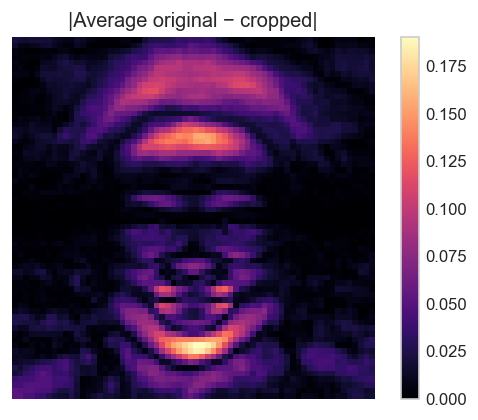

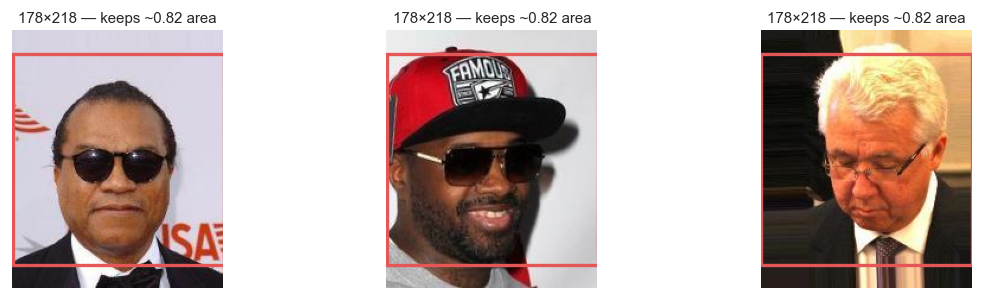

In [7]:
# 4a) Center-crop diagnostics (optional)
print("Diagnostics preview with:", 
{"target_size": cfg.diag_target_size, # 64
"sample": cfg.diag_visual_sample}) # 256
from src.celeba_workflow import preview_center_crop_diagnostics
preview_center_crop_diagnostics(cfg)



### 6. Preprocess Images — Crop, Resize, Normalize, Record

Preprocessing is about making sure the model sees a stable, predictable dataset.  
Each choice here serves that goal:  

- **Center-crop → resize (64×64)**: brings all images to the same scale and aspect ratio, so the CNN learns features, not framing quirks.  
- **Normalize to [0,1]**: keeps pixel values on a common scale, which stabilizes training and makes hyperparameters more portable.  
- **Compute channel mean/std on train split**: captures the dataset’s color baseline, so loaders can normalize consistently.  
- **Preserve split/class structure and receipts**: ensures downstream experiments are reproducible and auditable.  

---

#### What we got
- **Processed root**: `data/celeba/processed/eyeglasses_balanced_20k_64`  
- **Total images**: 20,000 (16k train • 2k val • 2k test)  
- **By class**: 10k eyeglasses • 10k no_eyeglasses  
- Receipts written: updated `processed_index.csv` (with sizes), plus summary files  

---

These steps turn a raw subset into a stable training set.  
The model now sees data that is consistent, balanced, and reproducible — no hidden quirks left to derail comparisons.


In [8]:
# 4b) Preprocess images
from src.nb_display import _relpath
print("Preprocess with:", {
    "subset_root": _relpath(cfg.subset_root), # data/celeba/subsets/eyeglasses_balanced_20k
    "out_root": _relpath(cfg.out_root), # data/celeba/processed/eyeglasses_balanced_20k_64
    "size": cfg.preprocess_size, # 64
    "center_crop": cfg.preprocess_center_crop, # True
    "normalize_01": cfg.preprocess_normalize_01, # True
    "compute_stats": cfg.preprocess_compute_stats, # True
})
from src.celeba_workflow import preprocess_images_only
preprocess_images_only(cfg)

Preprocess with: {'subset_root': 'data/celeba/subsets/eyeglasses_balanced_20k', 'out_root': 'data/celeba/processed/eyeglasses_balanced_20k_64', 'size': 64, 'center_crop': True, 'normalize_01': True, 'compute_stats': True}


Measuring processed sizes: 100%|██████████| 20000/20000 [00:01<00:00, 10078.36it/s]
INFO: Updated processed_index.csv with width/height columns
INFO: Summary:
INFO: - Processed root: data/celeba/processed/eyeglasses_balanced_20k_64
INFO: - Total processed: 20000 | By split: {'test': 2000, 'train': 16000, 'val': 2000} | By class: {'eyeglasses': 10000, 'no_eyeglasses': 10000}


### 7. Verify Receipts

Preprocessing should leave a paper trail.  
Here we do a quick smoke test to confirm those artifacts exist and look healthy:

- **`manifest.csv`**: file-level metadata (hashes, sizes, paths)  
- **`data_ledger.json`**: index of receipts (stats, manifest, transforms, randomness)  

If either file is missing or malformed, stop here. Training without receipts means you can’t trust the run.

In [9]:
# Peek at receipts: manifest and data ledger
from pathlib import Path
import json
import pandas as pd
from src.nb_display import _relpath

stats_dir = Path(cfg.out_root) / "stats"
man_path = stats_dir / "manifest.csv"
ledger_path = stats_dir / "data_ledger.json"

if man_path.exists():
    df = pd.read_csv(man_path)
    if "source_path" in df.columns:
        try:
            df["relative_source_path"] = df["source_path"].map(_relpath)
        except Exception:
            df["relative_source_path"] = df["source_path"]
        df = df.drop(columns=["source_path"])
    display(df.head(3))
else:
    print("manifest.csv not found at:", _relpath(man_path))

if ledger_path.exists():
    data = json.loads(ledger_path.read_text())
    print("data_ledger keys:", sorted(list(data.keys())))
else:
    print("data_ledger.json not found at:", _relpath(ledger_path))


image_id partition_name     class_name                       dest_path  \
0  115463.jpg          train  no_eyeglasses  train/no_eyeglasses/115463.jpg   
1  154735.jpg          train     eyeglasses     train/eyeglasses/154735.jpg   
2  123478.jpg          train     eyeglasses     train/eyeglasses/123478.jpg   

                                              sha256  size_bytes  \
0  3188eb4d20eb8fc622ab1d2a5d2ab9e8f2f0b033861fb2...        3115   
1  ae5d94e87bfaf38e4787bc8fcbc10a934610fbc5927987...        3152   
2  d418f3810265971fbd979c0cd097b37b40dbc0be0c2ac1...        2802   

                                relative_source_path  
0  data/celeba/subsets/eyeglasses_balanced_20k/tr...  
1  data/celeba/subsets/eyeglasses_balanced_20k/tr...  
2  data/celeba/subsets/eyeglasses_balanced_20k/tr...

data_ledger keys: ['counts', 'manifest_path', 'normalize_01', 'processing_summary_path', 'randomness_policy', 'size', 'stats_path', 'transform_policy']


### 8. Analyze the Processed Dataset (Post-Preprocessing)

Before training, we confirm the processed subset is both complete and consistent.  
This isn’t about numbers for their own sake, it’s about catching silent drift or mistakes before they cost us training time.  

---

#### What we checked
- **Counts**: 20,000 images total (16k train • 2k val • 2k test), perfectly balanced (50/50 eyeglasses vs no_eyeglasses).  
- **Geometry**: all images resized cleanly to 64×64 (aspect 1.0).  
- **Channel stats (TRAIN split)**: means ≈ (0.505, 0.425, 0.386), stds ≈ (0.305, 0.285, 0.285). Minimal drift compared to pre-processed values.  
- **Histograms**: pixel values span `[0,1]` cleanly; distribution shape preserved after normalization.  
- **Receipts check**: saved stats.json matches recomputed values within tolerance.  

---

The dataset is balanced, standardized, and verified.  
Training can now focus on modeling not debugging hidden quirks in the data.


Analyze processed: out_root=data/celeba/processed/eyeglasses_balanced_20k_64 | hist_bins=50


Accumulating channel stats: 100%|██████████| 1500/1500 [00:00<00:00, 4378.85it/s]


• Counts: total 20k | train 16k | val 2k | test 2k | 50/50
• Geometry: 64×64 (all)
• Stats: saved vs recomputed WARN (Δ mean ≤ 0.005, Δ std ≤ 0.010)


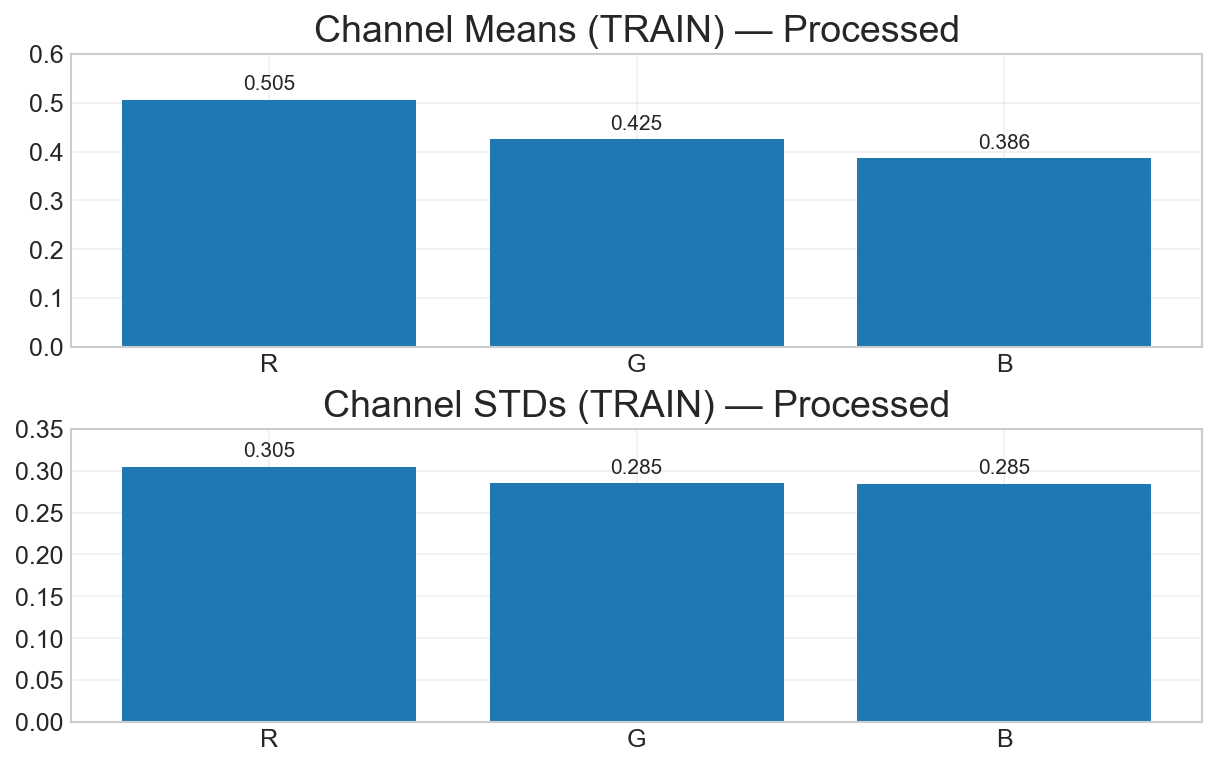

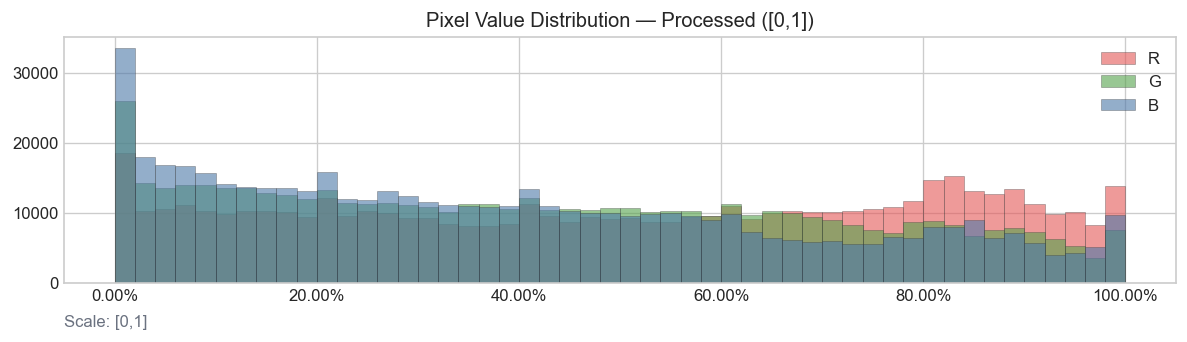

In [10]:
# 5) Analyze processed dataset
from src.nb_display import _relpath
print(f"Analyze processed: out_root={_relpath(cfg.out_root)} | hist_bins={cfg.proc_pixel_hist_bins}")

res = analyze_processed(cfg, verbosity="brief")
